In [ ]:
import numpy as np
import pandas as pd

In [ ]:
taxi=pd.read_csv('kolkata_taxi_data.csv')
taxi.head()

FileNotFoundError: [Errno 2] No such file or directory: 'kolkata_taxi_data.csv'

In [ ]:
demography=pd.read_csv('kolkata_demography_table.csv')
demography.head()

,Zip Code,Location,Area Type,Population,Average Monthly Earning (INR)
0,700001,B.B.D. Bagh,Commercial,10000,80000
1,700007,Esplanade,Commercial,12000,82000
2,700013,Chittaranjan Avenue,Commercial,11000,81000
3,700014,Bhowanipore,Residential,90000,65000
4,700016,Park Street,Commercial,15000,85000


In [ ]:
joined=pd.merge(taxi[['Date','Zip Code', 'Number of Trips Booked']],demography[['Zip Code', 'Population', 'Average Monthly Earning (INR)']], on='Zip Code', how='left')
print(joined)
joined.head()

             Date  Zip Code  Number of Trips Booked  Population  \
0      2024/01/01    700001                      22       10000   
1      2024/01/01    700007                      29       12000   
2      2024/01/01    700013                      19       11000   
3      2024/01/01    700014                      17       90000   
4      2024/01/01    700016                      15       15000   
...           ...       ...                     ...         ...   
19995  2024/12/29    700085                       8       63000   
19996  2024/12/29    700086                       5       79000   
19997  2024/12/29    700088                       4       67000   
19998  2024/12/29    700095                       8       72000   
19999  2024/12/29    700099                       7       68000   

       Average Monthly Earning (INR)  
0                              80000  
1                              82000  
2                              81000  
3                              65000  


,Date,Zip Code,Number of Trips Booked,Population,Average Monthly Earning (INR)
0,2024/01/01,700001,22,10000,80000
1,2024/01/01,700007,29,12000,82000
2,2024/01/01,700013,19,11000,81000
3,2024/01/01,700014,17,90000,65000
4,2024/01/01,700016,15,15000,85000


#### Mutual Information between 'Number of Trips Booked' and 'Population'

In [ ]:
from sklearn.metrics import mutual_info_score

X= joined['Number of Trips Booked']
Y= joined['Population']

mi_population= mutual_info_score(X,Y)
print(mi_population)

0.3528375402139743


####Mutual Information between 'Number of Trips Booked' and 'Average Monthly Earning (INR)'

In [ ]:
Z= joined['Average Monthly Earning (INR)']

mi_income= mutual_info_score(X,Z)
print(mi_income)

0.3403697165877676


##MI estimation using LV2SK

In [ ]:
!pip install mmh3

In [ ]:
import mmh3

def mmh3_hash(x, seed=0):
    return mmh3.hash(str(x), seed) & 0xffffffff

sketch_size=1000

def lv2sk_sampling(T, A, keyT, keyA, desT, desA ,sketch_size=500, h=mmh3_hash):
  # Get top n keys using the hash function
  common_keys = set(T[keyT]).intersection(set(A[keyA]))
  sorted_keys = sorted(common_keys, key=h)[:sketch_size]

  # Select rows from each table using selected keys
  T_sketch = T[T[keyT].isin(sorted_keys)]
  A_sketch = A[A[keyA].isin(sorted_keys)]

  # Manually align rows by key without setting index
  result = []
  for key in sorted_keys:
      x_rows = T_sketch[T_sketch[keyT] == key][desT]
      y_rows = A_sketch[A_sketch[keyA] == key][desA]
      min_len = min(len(x_rows), len(y_rows))
      result.extend(zip(x_rows.iloc[:min_len], y_rows.iloc[:min_len]))

  return pd.DataFrame(result, columns=[desT, desA])



In [ ]:
lv2sk_population= lv2sk_sampling(taxi, demography, 'Zip Code', 'Zip Code','Number of Trips Booked', 'Population', sketch_size)
print(lv2sk_population)

    Number of Trips Booked  Population
0                       11       62000
1                       27       14000
2                       27       13000
3                       11       68000
4                       12       60000
5                       19       72000
6                       13       67000
7                       22       12000
8                        6       72000
9                       17       76000
10                      17       85000
11                      13       67000
12                      19       11000
13                      25       13000
14                       7       73000
15                      11       74000
16                      12       70000
17                      17       90000
18                      15       78000
19                      10       82000
20                      19       74000
21                      14       63000
22                       8       60000
23                      17       65000
24                      2

In [ ]:
X_lv2sk_population= lv2sk_population['Number of Trips Booked']
Y_lv2sk_population= lv2sk_population['Population']

mi_population_lv2sk= mutual_info_score(X_lv2sk_population,Y_lv2sk_population)
print(mi_population_lv2sk)

2.338491359572667


In [ ]:
lv2sk_income= lv2sk_sampling(taxi, demography, 'Zip Code', 'Zip Code','Number of Trips Booked', 'Average Monthly Earning (INR)', sketch_size=500)
print(lv2sk_income)

    Number of Trips Booked  Average Monthly Earning (INR)
0                       11                          59000
1                       27                          84000
2                       27                          83000
3                       11                          61000
4                       12                          58000
5                       19                          61000
6                       13                          61000
7                       22                          82000
8                        6                          65000
9                       17                          60000
10                      17                          68000
11                      13                          61000
12                      19                          81000
13                      25                          83000
14                       7                          62000
15                      11                          62000
16            

In [ ]:
X_lv2sk_income= lv2sk_income['Number of Trips Booked']
Y_lv2sk_income= lv2sk_income['Average Monthly Earning (INR)']

mi_income_lv2sk= mutual_info_score(X_lv2sk_income,Y_lv2sk_income)
print(mi_income_lv2sk)

1.7379551395896555


##MI Estimation using TUPSK

In [ ]:
def tupsk_sampling(T, A, keyT, keyA, desT, desA ,sketch_size=500, h=mmh3_hash):
    T_temp = T.copy()
    A_temp = A.copy()

    T_temp['row_id'] = T_temp.groupby(keyT).cumcount()
    A_temp['row_id'] = A_temp.groupby(keyA).cumcount()

    T_temp['hash'] = T_temp.apply(lambda r: h((r[keyT], r['row_id'])), axis=1)
    A_temp['hash'] = A_temp.apply(lambda r: h((r[keyA], r['row_id'])), axis=1)

    T_temp = T_temp.sort_values('hash').head(sketch_size)
    A_temp = A_temp.sort_values('hash').head(sketch_size)

    # Merge on row index for final pairing (not join on key)
    min_len = min(len(T_temp), len(A_temp))
    return pd.DataFrame({
        desT: T_temp[desT].iloc[:min_len].values,
        desA: A_temp[desA].iloc[:min_len].values
    })

In [ ]:
tupsk_population=tupsk_sampling(taxi, demography, 'Zip Code', 'Zip Code','Number of Trips Booked', 'Population', sketch_size)
print(tupsk_population)

    Number of Trips Booked  Population
0                       10       54000
1                       12       69000
2                       15       60000
3                       10       56000
4                       14       60000
5                       20       78000
6                       27       71000
7                       33       70000
8                       22       75000
9                        8       10000
10                       9       52000
11                      34       70000
12                      33       74000
13                      17       63000
14                      13       10000
15                      13       14000
16                       9       72000
17                      17       12000
18                      22       95000
19                       8       60000
20                      15       73000
21                      28       76000
22                      12       72000
23                      14       68000
24                      2

In [ ]:
X_tupsk_population= tupsk_population['Number of Trips Booked']
Y_tupsk_population= tupsk_population['Population']

mi_population_tupsk= mutual_info_score(X_lv2sk_population,Y_lv2sk_population)
print(mi_population_tupsk)

2.338491359572667


In [ ]:
tupsk_income=tupsk_sampling(taxi, demography, 'Zip Code', 'Zip Code','Number of Trips Booked', 'Average Monthly Earning (INR)', sketch_size=500)
print(tupsk_income)

    Number of Trips Booked  Average Monthly Earning (INR)
0                       10                          71000
1                       12                          60000
2                       15                          70000
3                       10                          69000
4                       14                          58000
5                       20                          67000
6                       27                          61000
7                       33                          60000
8                       22                          69000
9                        8                          80000
10                       9                          73000
11                      34                          62000
12                      33                          62000
13                      17                          59000
14                      13                          80000
15                      13                          84000
16            

In [ ]:
X_tupsk_income= tupsk_income['Number of Trips Booked']
Y_tupsk_income= tupsk_income['Average Monthly Earning (INR)']

mi_income_tupsk= mutual_info_score(X_tupsk_income,Y_tupsk_income)
print(mi_income_tupsk)

1.6988439564497253


##MI Estimation using TUPSK

####Tuning B, alpha and eps

In [ ]:
B=10 #Bootstrap Size
alpha=3.0  #Information limit
eps=1e-4  #Tolernce

In [ ]:
def kaigs_sampling(T, A, keyT, keyA, desT, desA, B=5, alpha=2.0, eps=1e-6, seed=0):
    np.random.seed(seed)
    grouped_T = T.groupby(keyT)
    grouped_A = A.groupby(keyA)

    result = []
    common_keys = set(grouped_T.groups).intersection(set(grouped_A.groups))

    for key in common_keys:
        group_T = grouped_T.get_group(key)
        group_A = grouped_A.get_group(key)

        if len(group_T) == 0 or len(group_A) == 0:
            continue

        S_boot = group_A.sample(n=min(B, len(group_A)), replace=True)
        dist_before = S_boot[desA].value_counts(normalize=True)
        H_before = -np.sum([p * np.log(p + eps) for p in dist_before])

        deltas = []
        for i, row in group_A.iterrows():
            with_row = pd.concat([S_boot, row.to_frame().T])
            dist_after = with_row[desA].value_counts(normalize=True)
            H_after = -np.sum([p * np.log(p + eps) for p in dist_after])
            delta = H_before - H_after
            deltas.append((i, delta))

        total_delta = sum(delta + eps for _, delta in deltas)
        weights = [(delta + eps) / total_delta for _, delta in deltas]

        for (i, delta), w in zip(deltas, weights):
            pr = min(1.0, alpha * w * np.sqrt(len(group_A) / len(A)))
            if np.random.rand() < pr:
                y = group_A.loc[i, desA]
                x_vals = group_T[desT].values
                for x in x_vals:
                    result.append((x, y))

    return pd.DataFrame(result, columns=['X', 'Y'])

In [ ]:
kaigs_population=kaigs_sampling(taxi, demography, 'Zip Code', 'Zip Code','Number of Trips Booked', 'Population', B, alpha, eps)
print(kaigs_population)

       X      Y
0     11  62000
1     15  62000
2     13  62000
3     20  62000
4     20  62000
...   ..    ...
5813  10  80000
5814  17  80000
5815  12  80000
5816  13  80000
5817   2  80000

[5818 rows x 2 columns]


In [ ]:
X_kaigs_population= kaigs_population['X']
Y_kaigs_population= kaigs_population['Y']

mi_population_kaigs= mutual_info_score(X_kaigs_population,Y_kaigs_population)
print(mi_population_kaigs)

0.3433563550759072


In [ ]:
kaigs_income=kaigs_sampling(taxi, demography, 'Zip Code', 'Zip Code','Number of Trips Booked', 'Average Monthly Earning (INR)', B, alpha, eps)
print(kaigs_income)

       X      Y
0     11  59000
1     15  59000
2     13  59000
3     20  59000
4     20  59000
...   ..    ...
5813  10  64000
5814  17  64000
5815  12  64000
5816  13  64000
5817   2  64000

[5818 rows x 2 columns]


In [ ]:
X_kaigs_income= kaigs_income['X']
Y_kaigs_income= kaigs_income['Y']

mi_income_kaigs= mutual_info_score(X_kaigs_income,Y_kaigs_income)
print(mi_income_kaigs)

0.32965937576019655


##Plotting

####MI using different sampling methods

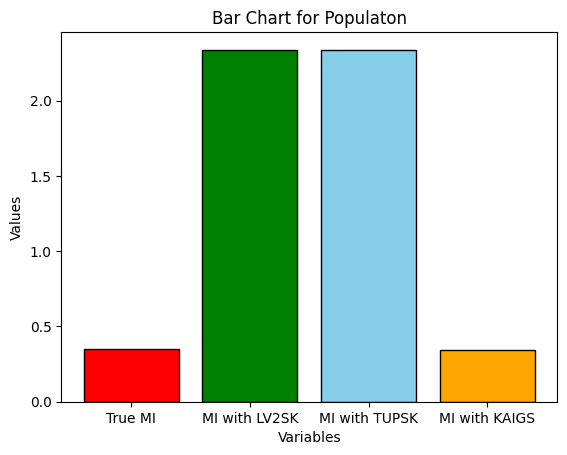

In [ ]:
import matplotlib.pyplot as plt

# Your values
values_population = [mi_population, mi_population_lv2sk, mi_population_tupsk, mi_population_kaigs]
labels = ['True MI', 'MI with LV2SK', 'MI with TUPSK', 'MI with KAIGS']
colors = ['red', 'green', 'skyblue', 'orange']

# Create a bar chart
plt.bar(labels, values_population, color=colors, edgecolor='black')

# Add title and labels
plt.title('Bar Chart for Populaton')
plt.xlabel('Variables')
plt.ylabel('Values')

# Show the plot
plt.show()


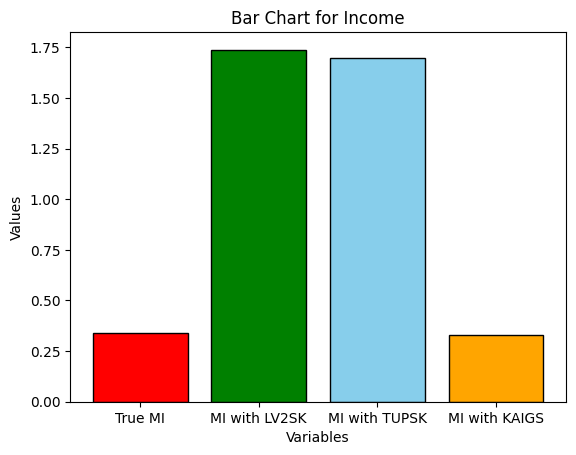

In [ ]:
import matplotlib.pyplot as plt

# Your values
values_income = [mi_income, mi_income_lv2sk, mi_income_tupsk, mi_income_kaigs]
labels = ['True MI', 'MI with LV2SK', 'MI with TUPSK', 'MI with KAIGS']
colors = ['red', 'green', 'skyblue', 'orange']

# Create a bar chart
plt.bar(labels, values_income, color = colors, edgecolor='black')

# Add title and labels
plt.title('Bar Chart for Income')
plt.xlabel('Variables')
plt.ylabel('Values')

# Show the plot
plt.show()


####Sketch Size comparison

In [ ]:
print(f"Size of the joined table: {len(joined)}")
print("Sketch Sizes for Population>")
print(f"LV2SK: {len(lv2sk_population)}")
print(f"TUPSK: {len(tupsk_population)}")
print(f"KAIGS: {len(kaigs_population)}")

Size of the joined table: 20000
Sketch Sizes for Population>
LV2SK: 55
TUPSK: 55
KAIGS: 5818


In [ ]:
print("Sketch Sizes for Income>")
print(f"LV2SK: {len(lv2sk_income)}")
print(f"TUPSK: {len(tupsk_income)}")
print(f"KAIGS: {len(kaigs_income)}")

Sketch Sizes for Income>
LV2SK: 55
TUPSK: 55
KAIGS: 5818
